In [5]:
from nltk.corpus import wordnet as wn
# import nltk
# nltk.download("wordnet")
panda = wn.synset("panda.n.01")
hyper = lambda s: s.
list(panda.closure(hyper))

AttributeError: 'Synset' object has no attribute 'hypernums'

**遗留问题：**<br>
1. 缩放点积中的dk是方差，为什么在代码中是用的最后一个维度的大小表示？<br>
2. tf.shape()和tensor.shape的区别是什么？<br>
3. 训练时创建masks时inp和targ_inp的数据形式好像发生了变化？

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)
matplotlib 3.1.3
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.1
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


## 1. 数据准备和处理

In [7]:
import tensorflow_datasets as tfds

examples, info = tfds.load("ted_hrlr_translate/pt_to_en",
                           with_info=True,
                           as_supervised=True)
train_examples, val_examples = examples["train"], examples["validation"]
print(info)

tfds.core.DatasetInfo(
    name='ted_hrlr_translate',
    version=0.0.1,
    description='Data sets derived from TED talk transcripts for comparing similar language pairs
where one is high resource and the other is low resource.
',
    urls=['https://github.com/neulab/word-embeddings-for-nmt'],
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'pt': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=54781,
    splits={
        'test': 1803,
        'train': 51785,
        'validation': 1193,
    },
    supervised_keys=('pt', 'en'),
    citation="""@inproceedings{Ye2018WordEmbeddings,
      author  = {Ye, Qi and Devendra, Sachan and Matthieu, Felix and Sarguna, Padmanabhan and Graham, Neubig},
      title   = {When and Why are pre-trained word embeddings useful for Neural Machine Translation},
      booktitle = {HLT-NAACL},
      year    = {2018},
      }""",
    redistribution_info=,
)



In [8]:
for pt, en in train_examples.take(5):
    print(pt.numpy())
    print(en.numpy())
    print("-------------------")

b'os astr\xc3\xb3nomos acreditam que cada estrela da gal\xc3\xa1xia tem um planeta , e especulam que at\xc3\xa9 um quinto deles tem um planeta do tipo da terra que poder\xc3\xa1 ter vida , mas ainda n\xc3\xa3o vimos nenhum deles .'
b"astronomers now believe that every star in the galaxy has a planet , and they speculate that up to one fifth of them have an earth-like planet that might be able to harbor life , but we have n't seen any of them ."
-------------------
b'o problema \xc3\xa9 que nunca vivi l\xc3\xa1 um \xc3\xbanico dia .'
b"except , i 've never lived one day of my life there ."
-------------------
b'agora aqui temos imagens sendo extra\xc3\xaddas em tempo real diretamente do feed ,'
b'now here are live images being pulled straight from the feed .'
-------------------
b'agora : um , dois , tr\xc3\xaas , vai .'
b'so : one , two , three , go .'
-------------------
b'eventualmente , vamos ver se teremos todos os sentidos humanos empregues , e se vamos ter meios para viver a hist

In [4]:
en_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples),
    target_vocab_size=2 ** 13)
pt_tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples),
    target_vocab_size=2 ** 13)

In [5]:
sample_string = "Transformer is awesome."

tokenized_string = en_tokenizer.encode(sample_string)
print("Tokenized string is: {}".format(tokenized_string))

origin_string = en_tokenizer.decode(tokenized_string)
print("The original string is: {}".format(origin_string))

assert origin_string == sample_string

for token in tokenized_string:
    print('{} --> "{}"'.format(token, en_tokenizer.decode([token])))

Tokenized string is: [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string is: Transformer is awesome.
7915 --> "T"
1248 --> "ran"
7946 --> "s"
7194 --> "former "
13 --> "is "
2799 --> "awesome"
7877 --> "."


In [6]:
buffer_size = 20000
batch_size = 64
max_length = 40

def encode_to_subword(pt_sentence, en_sentence):
    pt_sequence = [pt_tokenizer.vocab_size] \
    + pt_tokenizer.encode(pt_sentence.numpy()) \
    + [pt_tokenizer.vocab_size + 1]
    
    en_sequence = [en_tokenizer.vocab_size] \
    + en_tokenizer.encode(en_sentence.numpy()) \
    + [en_tokenizer.vocab_size + 1]
    
    return pt_sequence, en_sequence

def filter_by_max_length(pt, en):
    return tf.logical_and(tf.size(pt) <= max_length,
                          tf.size(en) <= max_length)

def tf_encode_to_subword(pt_sentence, en_sentence):
    return tf.py_function(encode_to_subword,
                          [pt_sentence, en_sentence],
                          [tf.int64, tf.int64])

train_dataset = train_examples.map(tf_encode_to_subword)
train_dataset = train_dataset.filter(filter_by_max_length)
train_dataset = train_dataset.shuffle(
    buffer_size).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))

valid_dataset = val_examples.map(tf_encode_to_subword)
valid_dataset = valid_dataset.filter(
    filter_by_max_length).padded_batch(
    batch_size, padded_shapes=([-1], [-1]))

for pt_batch, en_batch in valid_dataset.take(5):
    print(pt_batch.shape, en_batch.shape)

(64, 38) (64, 40)
(64, 39) (64, 35)
(64, 39) (64, 39)
(64, 39) (64, 39)
(64, 39) (64, 36)


In [7]:
for pt, en in train_examples.take(3):
    print(en)

tf.Tensor(b'and when you improve searchability , you actually take away the one advantage of print , which is serendipity .', shape=(), dtype=string)
tf.Tensor(b'but what if it were active ?', shape=(), dtype=string)
tf.Tensor(b"but they did n't test for curiosity .", shape=(), dtype=string)


## 2. 模型构建

### 2.1 position embedding

In [8]:
# PE(pos, 2i)    =  sin( pos / 10000^( 2i / d_model ))
# PE(pos, 2i+1)  =  cos( pos / 10000^( 2i / d_model ))

# pos.shape    : [sentence_length, 1]
# i.shape      : [1, d_model]
# result.shape : [sentence_length, d_model]
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000,
                              (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def get_position_embedding(sentence_length, d_model):
    angle_rates = get_angles(np.arange(sentence_length)[:, np.newaxis],
                             np.arange(d_model)[np.newaxis, :],
                             d_model)
    # sines.shape   : [sentence_length, d_model / 2]
    # cosines.shape : [sentence_length, d_model / 2]
    sines = np.sin(angle_rates[ : , 0::2])
    cosines = np.cos(angle_rates[ : , 1::2])
    
    # position_embedding.shape: [sentence_length, d_model]
    position_embedding = np.concatenate([sines, cosines], axis=-1)

    
    position_embedding.shape: [1, sentence_length, d_model]
    position_embedding = position_embedding[np.newaxis, ...]

#     angle_rates[:, 0::2] = np.sin(angle_rates[:, 0::2])
#     angle_rates[:, 1::2] = np.cos(angle_rates[:, 1::2])
#     position_embedding = angle_rates[np.newaxis, ...]
    
    return tf.cast(position_embedding, dtype=tf.float32)

position_embedding = get_position_embedding(50, 512)
print(position_embedding.shape)

(1, 50, 512)


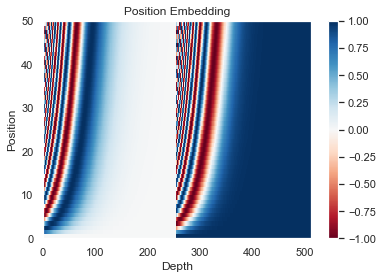

In [9]:
def plot_position_embedding(position_embedding):
    plt.pcolormesh(position_embedding[0], cmap="RdBu")
    plt.xlabel("Depth")
    plt.xlim((0, 512))
    plt.ylabel("Position")
    plt.title("Position Embedding")
    plt.colorbar()  # 配色版，右边那个柱状
    plt.show()
    
plot_position_embedding(position_embedding)

### 2.2 padding mask

In [10]:
# batch_data.shape : [batch_size, sequence_length]
def create_padding_mask(batch_data):
    padding_mask = tf.cast(tf.math.equal(batch_data, 0), tf.float32)
    # [batch_size, 1, 1, sequence_length]
    return padding_mask[:, tf.newaxis, tf.newaxis, :]

x = tf.constant([[2, 0, 1, 6, 0],
                 [1, 2, 3, 0, 0],
                 [0, 0, 0, 1, 2]])
create_padding_mask(x)

<tf.Tensor: id=208933, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 1., 0., 0., 1.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

### 2.3 look ahead mask

In [11]:
# attention_weights.shape: [3, 3]
# [[1, 0, 0],
#  [4, 5, 0],
#  [7, 8, 9]]
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask # (sequence_length, sequence_length)

create_look_ahead_mask(3)

<tf.Tensor: id=208941, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

### 2.4 scaled dot product attention

In [12]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    - q: shape == (..., seq_len_q, depth)
    - k: shape == (..., seq_len_k, depth)
    - v: shape == (..., seq_len_v, depth_v)
    - seq_len_k == seq_len_v
    - mask: shape == (..., seq_len_q, seq_len_k)
    Returns:
    - output: weighted sum
    - attention_weights: weights of attention
    """
    
    # matmul_qk.shape: (..., seq_len_q, seq_len_k)
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        # 使得在softmax后值趋近于0
        scaled_attention_logits += (mask * -1e9)
    
    # attention_weights.shape: (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(
        scaled_attention_logits, axis=-1)
    
    # output.shape: (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

def print_scaled_dot_product_attention(q, k ,v):
    temp_out, temp_att = scaled_dot_product_attention(q, k, v, None)
    print("Attention weights arg: ")
    print(temp_att)
    print("Output is: ")
    print(temp_out)

In [13]:
temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)   # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)   # (4, 2)

In [14]:
temp_q1 = tf.constant([[0, 10, 0]], dtype=tf.float32)   # (1, 3)
np.set_printoptions(suppress=True)
print_scaled_dot_product_attention(temp_q1, temp_k, temp_v)

Attention weights arg: 
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is: 
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [15]:
temp_q2 = tf.constant([[0, 0, 10]], dtype=tf.float32)   # (1, 3)
print_scaled_dot_product_attention(temp_q2, temp_k, temp_v)

Attention weights arg: 
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is: 
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [16]:
temp_q3 = tf.constant([[10, 10, 0]], dtype=tf.float32)   # (1, 3)
print_scaled_dot_product_attention(temp_q3, temp_k, temp_v)

Attention weights arg: 
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is: 
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [17]:
temp_q4 = tf.concat([temp_q1, temp_q2, temp_q3], axis=0)   # (3, 3)
print_scaled_dot_product_attention(temp_q4, temp_k, temp_v)

Attention weights arg: 
tf.Tensor(
[[0.  1.  0.  0. ]
 [0.  0.  0.5 0.5]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is: 
tf.Tensor(
[[ 10.    0. ]
 [550.    5.5]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### 2.5 MultiHeadAttention

In [18]:
class MultiHeadAttention(keras.layers.Layer):
    """
    理论上：
    x -> Wq0 -> q0,  x -> Wq1 -> q1, ...
    x -> wk0 -> k0,  x -> Wk1 -> k1, ...
    x -> wv0 -> v0,  x -> Wv1 -> v1, ...
    
    在不同场景中，x(输入)是不同的，比如在self-attention中，输入（以下所述中
    的q,k,v）相同，但是在encoder-decoder连接中的attention输入是不相同的（
    以下所述中的k,v相同，但是q不同），所以在实践中，直接将输入分成三种q,k,v
    
    实战中：
    q -> Wq0 -> q0,  q -> Wq1 -> q1, ...
    k -> wk0 -> k0,  k -> Wk1 -> k1, ...
    v -> wv0 -> v0,  v -> Wv1 -> v1, ...
    
    实战中技巧：
    q -> Wq -> Q -> split -> q0, q1, q2, ...
    k -> Wk -> K -> split -> k0, k1, k2, ...
    v -> Wv -> V -> split -> v0, v1, v2, ...
    """
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert self.d_model % self.num_heads == 0
        
        self.depth = self.d_model // self.num_heads
        
        self.WQ = keras.layers.Dense(self.d_model)
        self.WK = keras.layers.Dense(self.d_model)
        self.WV = keras.layers.Dense(self.d_model)
        
        self.dense = keras.layers.Dense(self.d_model)
        
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, q, k, v, mask):
        batch_size = tf.shape(q)[0]
        
        # q.shape: (batch_size, seq_len_q, d_model)
        # k.shape: (batch_size, seq_len_k, d_model)
        # v.shape: (batch_size, seq_len_v, d_model)
        # 其中 q,k 的d_model应该是相同的，它们与v的d_model可以不同
        q = self.WQ(q) 
        k = self.WK(k) 
        v = self.WV(v) 
        
        # q.shape：(batch_size, num_heads, seq_len_q, depth)
        # k.shape: (batch_size, num_heads, seq_len_k, depth)
        # v.shape: (batch_size, num_heads, seq_len_v, depth)
        # 其中 seq_len_k 应该与 seq_len_v 相同
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        # scaled_attention_outputs.shape: 
            # (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape: 
            # (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention_outputs, attention_weights = \
        scaled_dot_product_attention(q, k, v, mask)
        
        # scaled_attention_outputs.shape:
            # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention_outputs = tf.transpose(
            scaled_attention_outputs, perm=[0, 2, 1, 3])
        
        # concat_attention.shape: [batch_size, seq_len_q, d_model]
        concat_attention = tf.reshape(scaled_attention_outputs, 
                                      [batch_size, -1, self.d_model])
        
        # output.shape : (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)
        
        return output, attention_weights

In [19]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 256)) # (batch_size, seq_len_q, dim)
output, attention = temp_mha(y, y, y, mask=None)
print(output.shape)
print(attention.shape)

(1, 60, 512)
(1, 8, 60, 60)


### 2.6 feedforward layer

In [20]:
def feed_forward_network(hidden_units, output_units):
    # hidden_units: units of hidden layer.
    # output_units: units of output layer. (= d_model)
    return keras.models.Sequential([
        keras.layers.Dense(hidden_units, activation="relu"),
        keras.layers.Dense(output_units)
    ])

sample_ffn = feed_forward_network(2048, 512)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

### 2.7 Encoder Layer

In [21]:
class EncoderLayer(keras.layers.Layer):
    """
    x -> self attention -> add & normalize & dropout
      -> feedforward  -> add & normalize & dropout
    """
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = feed_forward_network(dff, d_model)
        
        self.layer_norml1 = keras.layers.LayerNormalization(epsilon=1e-6)
        self.layer_norml2 = keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        # x.shape            : (batch_size, seq_len, dim=d_model)
        # attn_output.shape  : (batch_size, seq_len, d_model)
        # out1.shape         : (batch_size, seq_len, d_model)
        attn_output, attention_weights = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output,
                                    training=training)  # dropout层在训练和预测                                                         # 时模式是不同的
        out1 = self.layer_norml1(x + attn_output) # 约束了x和attn_output维度相同
        
        # ffn_output.shape: (batch_size, seq_len, d_model)
        # out2.shape      : (batch_size, seq_len, d_model)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layer_norml2(out1 + ffn_output)
        
        return out2

In [22]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_input = tf.random.uniform((64, 50, 512))
sample_output = sample_encoder_layer(sample_input, False, None)
print(sample_output.shape)

(64, 50, 512)


### 2.8 Decoder Layer

In [23]:
class DecoderLayer(keras.layers.Layer):
    """
    <step1>:
    x -> self attention -> add & normalize & dropout -> out1
    
    <step2>:
    out1, encoding_outputs -> attention -> add & normalize & dropout -> out2
    
    <step3>:
    out2 -> ffn -> add & normalize & dropout -> out3
    """
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = feed_forward_network(dff, d_model)
    
        self.layer_norm1 = keras.layers.LayerNormalization(
            epsilon=1e-6)
        self.layer_norm2 = keras.layers.LayerNormalization(
            epsilon=1e-6)
        self.layer_norm3 = keras.layers.LayerNormalization(
            epsilon=1e-6)
        
        self.dropout1 = keras.layers.Dropout(rate)
        self.dropout2 = keras.layers.Dropout(rate)
        self.dropout3 = keras.layers.Dropout(rate)
        
    def call(self, x, encoding_outputs, training, 
             look_ahead_mask, padding_mask):
        # x.shape: (batch_size, target_seq_len, d_model)
        # encoding_outputs.shape: (batch_size, input_seq_len, d_model)
        
        # attn1, out1.shape : (batch_size, target_seq_len, d_model)
        attn1, attn_weights1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layer_norm1(attn1 + x)
        
        # attn2, out2.shape : (batch_size, target_seq_len, d_model)
        attn2, attn_weights2 = self.mha2(
            out1, encoding_outputs, encoding_outputs, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layer_norm2(attn2 + out1)
        
        # ffn_output, out3.shape : (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layer_norm3(ffn_output + out2)
        
        return out3, attn_weights1, attn_weights2
    
sample_decoder_layer = DecoderLayer(512, 8, 2048)
sample_decoder_input = tf.random.uniform((64, 60, 512))
sample_decoder_output, sample_decoder_attn_weights1, sample_decoder_attn_weights2 = sample_decoder_layer(
    sample_decoder_input, sample_output, False, None, None)
print(sample_decoder_output.shape)
print(sample_decoder_attn_weights1.shape)
print(sample_decoder_attn_weights2.shape)

(64, 60, 512)
(64, 8, 60, 60)
(64, 8, 60, 50)


### 2.9 Encoder Model

In [24]:
class EncoderModel(keras.layers.Layer):
    def __init__(self, num_layers, input_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(EncoderModel, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.max_length = max_length
        
        self.embedding = keras.layers.Embedding(input_vocab_size,
                                                self.d_model)
        # position_embedding.shape: (1, max_length, d_model)
        self.position_embedding = get_position_embedding(max_length, 
                                                         self.d_model)
        self.dropout = keras.layers.Dropout(rate)
        self.encoder_layers = [
            EncoderLayer(d_model, num_heads, dff, rate)
            for _ in range(self.num_layers)]
    
    def call(self, x, training, mask):
        # x.shape: (batch_size, input_seq_len)
        input_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            input_seq_len, self.max_length,
            "input_seq_len should be less or equal to self.max_length")
        
        # x.shape: (batch_size, input_seq_len, d_model)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[ : , :input_seq_len, : ]
        
        x = self.dropout(x, training = training)
        
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, training, mask)
            
        # x.shape: (batch_size, input_seq_len, d_model)
        return x
    
sample_encoder_model = EncoderModel(2, 8500, max_length,
                                    512, 8, 2048)
sample_encoder_model_input = tf.random.uniform((64, 37))
sample_encoder_model_output = sample_encoder_model(sample_encoder_model_input,
                                                   False,
                                                   None)
print(sample_encoder_model_output.shape)

(64, 37, 512)


### 2.10 Decoder Model

In [25]:
class DecoderModel(keras.layers.Layer):
    def __init__(self, num_layers, target_vocab_size, max_length,
                 d_model, num_heads, dff, rate=0.1):
        super(DecoderModel, self).__init__()
        self.num_layers = num_layers
        self.max_length = max_length
        self.d_model = d_model
        
        self.embedding = keras.layers.Embedding(target_vocab_size,
                                                d_model)
        self.position_embedding = get_position_embedding(max_length,
                                                         d_model)
        self.dropout = keras.layers.Dropout(rate)
        self.decoder_layers = [
            DecoderLayer(d_model, num_heads, dff, rate) \
            for _ in range(num_layers)]
        
    def call(self, x, encoding_outputs, training, 
             look_ahead_mask, padding_mask):
        # x.shape: (batch_size, output_seq_len)
        output_seq_len = tf.shape(x)[1]
        tf.debugging.assert_less_equal(
            output_seq_len, self.max_length,
            "output_seq_len should be less or equal to self.max_length")
        
        attention_weights = {}
        
        # x.shape : (batch_size, output_seq_len, d_model)
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.position_embedding[ : , :output_seq_len, : ]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            x, attn1, attn2 = self.decoder_layers[i](
                x, encoding_outputs, training,
                look_ahead_mask, padding_mask)
            attention_weights[
                "decoder_layer{}_att1".format(i+1)] = attn1
            attention_weights[
                "decoder_layer{}_att2".format(i+1)] = attn2
        # x.shape: (batch_size, output_seq_len, d_model)
        return x, attention_weights
    
sample_decoder_model = DecoderModel(2, 8000, max_length,
                                    512, 8, 2048)
sample_decoder_model_input = tf.random.uniform((64, 35))
sample_decoder_model_output, sample_decoder_model_att \
    = sample_decoder_model(
        sample_decoder_model_input,
        sample_encoder_model_output,
        training=True, look_ahead_mask=None,
        padding_mask=None)

print("sample_decoder_model_output.shape: ", sample_decoder_model_output.shape)
for key, value in sample_decoder_model_att.items():
    print("{}.shape: {}".format(key, value.shape))

sample_decoder_model_output.shape:  (64, 35, 512)
decoder_layer1_att1.shape: (64, 8, 35, 35)
decoder_layer1_att2.shape: (64, 8, 35, 37)
decoder_layer2_att1.shape: (64, 8, 35, 35)
decoder_layer2_att2.shape: (64, 8, 35, 37)


### 2.11 Transformer

In [26]:
class Transformer(keras.models.Model):
    def __init__(self, num_layers, input_vocab_size, target_vocab_size,
                 max_length, d_model, num_heads, dff, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder_model = EncoderModel(num_layers, input_vocab_size, 
                                          max_length, d_model, 
                                          num_heads, dff, rate)
        
        self.decoder_model = DecoderModel(num_layers, target_vocab_size, 
                                          max_length, d_model, num_heads,
                                          dff, rate)
        
        self.final_layer = keras.layers.Dense(target_vocab_size)
        
    def call(self, inp, targ, training, encoder_padding_mask,
             look_ahead_mask, decoder_padding_mask):
        # encoding_outputs.shape : (batch_size, input_seq_len, d_model)
        encoding_outputs = self.encoder_model(inp, training,
                                              encoder_padding_mask)
        
        # decding_outputs.shape : (batch_size, target_seq_len, d_model)
        decoding_outputs, attention_weights = self.decoder_model(
            targ, encoding_outputs, training, 
            look_ahead_mask, decoder_padding_mask)
        
        # predictions.shape : (batch_size, output_seq_len, target_vocab_size)
        predictions = self.final_layer(decoding_outputs)
        
        return predictions, attention_weights
sample_transformer = Transformer(2, 8500, 8000, max_length,
                                 512, 8, 2048, rate=0.1)
temp_input = tf.random.uniform((64, 26))
temp_target = tf.random.uniform((64, 31))

predictions, attention_weights = sample_transformer(temp_input, 
                                                    temp_target, 
                                                    training=False,
                                                    encoder_padding_mask=None,
                                                    look_ahead_mask=None,
                                                    decoder_padding_mask=None)
print("Predictions.shape: ", predictions.shape)
for key, value in attention_weights.items():
    print("{}.shape: {}".format(key, value.shape))

Predictions.shape:  (64, 31, 8000)
decoder_layer1_att1.shape: (64, 8, 31, 31)
decoder_layer1_att2.shape: (64, 8, 31, 26)
decoder_layer2_att1.shape: (64, 8, 31, 31)
decoder_layer2_att2.shape: (64, 8, 31, 26)


### 2.12 设置超参数， 初始化模型

In [27]:
# 1. initialize model.
# 2. define loss, optimizer, learning_rate schedule
# 3.train_step
# 4. train process

In [28]:
num_layers = 8
d_model= 128
dff = 512
num_heads = 8

input_vocab_size = pt_tokenizer.vocab_size + 2
target_vocab_size = en_tokenizer.vocab_size + 2

dropout_rate = 0.1

transformer = Transformer(num_layers,
                          input_vocab_size,
                          target_vocab_size,
                          max_length,
                          d_model, 
                          num_heads, 
                          dff, 
                          dropout_rate)

### 2.13 自定义学习率

In [29]:
# learning rate = (d_model ** (-0.5)) * min(step_num ** (-0.5),
#                                         step_num * warm_up_steps ** (-1.5))
class CustomizedSchedule(
    keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomizedSchedule, self).__init__()

        self.d_model = tf.cast(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** (-1.5))
        arg3 = tf.math.rsqrt(self.d_model)
        return arg3 * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomizedSchedule(d_model)
optimizer = keras.optimizers.Adam(learning_rate,
                                  beta_1=0.9,
                                  beta_2=0.98,
                                  epsilon=1e-9)
    
    


Text(0.5, 0, 'Train step')

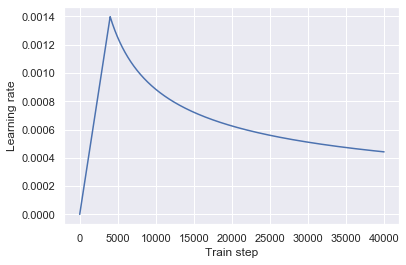

In [30]:
temp_learning_rate_schedule = CustomizedSchedule(d_model)

plt.plot(
    temp_learning_rate_schedule(
        tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning rate")
plt.xlabel("Train step")

In [31]:
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none")

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

### 2.14 Mask 创建与使用

In [32]:
def create_masks(inp, tar):
    """
    Encoder:
        - encoder_padding_mask (self attention of EncoderLayer)
    Decoder:
        - look_ahead_mask (self attention of DecoderLayer)
        - encoder_decoder_padding_mask (encoder-decoder attnetion of Decoder)
        - decoder_padding_mask(self attention of DecoderLayer)
    """
    encoder_padding_mask = create_padding_mask(inp)
    encoder_decoder_padding_mask = create_padding_mask(inp)
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
   
    decoder_padding_mask = create_padding_mask(tar)
    decoder_mask = tf.maximum(decoder_padding_mask, look_ahead_mask)
    
    return encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask

In [33]:
temp_inp, temp_tar = iter(train_dataset.take(1)).next()

print("temp_inp.shape: ", temp_inp.shape)
print("temp_tar.shape: ", temp_tar.shape)
encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
    =create_masks(temp_inp, temp_tar)

temp_inp.shape:  (64, 36)
temp_tar.shape:  (64, 38)


### 2.15 train step

In [34]:
@tf.function
def train_step(inp, tar):
    tar_inp = tar[:,:-1]
    tar_real = tar[:,1:]
    
    encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
    = create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, True,
                                     encoder_padding_mask,
                                     decoder_mask,
                                     encoder_decoder_padding_mask)
        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)

## 3. 模型训练

In [ ]:
train_loss = keras.metrics.Mean(name="train_loss")
train_accuracy = keras.metrics.SparseCategoricalCrossentropy(
    name="train_accuracy")  # 计算这个值时并没有考虑mask，所以只在一定程度上代表某种趋势  
epochs = 1
for epoch in range(epochs):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
        if batch % 1 == 0:
            print("Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}".format(
                epoch+1, batch, train_loss.result(),
                train_accuracy.result()))
    print("Epoch {} Loss {:.4f} Accuracy {:.4f}".format(
        epoch+1, train_loss.result(), train_accuracy.result()))
    print("Time take for 1 epoch: {} sec\n".format(
        time.time() - start))

Epoch 1 Batch 0 Loss 3.8332 Accuracy 11.3606
Epoch 1 Batch 1 Loss 4.0749 Accuracy 11.4361
Epoch 1 Batch 2 Loss 4.1553 Accuracy 11.5032
Epoch 1 Batch 3 Loss 4.1313 Accuracy 11.4858
Epoch 1 Batch 4 Loss 4.1955 Accuracy 11.5353


Epoch 1 Batch 5 Loss 4.1893 Accuracy 11.5520


Epoch 1 Batch 6 Loss 4.2202 Accuracy 11.5839


Epoch 1 Batch 7 Loss 4.2005 Accuracy 11.5450
Epoch 1 Batch 8 Loss 4.2146 Accuracy 11.5328
Epoch 1 Batch 9 Loss 4.1846 Accuracy 11.4855
Epoch 1 Batch 10 Loss 4.1940 Accuracy 11.4779
Epoch 1 Batch 11 Loss 4.1803 Accuracy 11.4433
Epoch 1 Batch 12 Loss 4.1713 Accuracy 11.4158


Epoch 1 Batch 13 Loss 4.1971 Accuracy 11.4099
Epoch 1 Batch 14 Loss 4.1892 Accuracy 11.3880


Epoch 1 Batch 15 Loss 4.1897 Accuracy 11.3571


Epoch 1 Batch 16 Loss 4.1968 Accuracy 11.3470


Epoch 1 Batch 17 Loss 4.2215 Accuracy 11.3347


Epoch 1 Batch 18 Loss 4.2287 Accuracy 11.3166
Epoch 1 Batch 19 Loss 4.2195 Accuracy 11.2898


Epoch 1 Batch 20 Loss 4.2259 Accuracy 11.2692
Epoch 1 Batch 21 Loss 4.2195 Accuracy 11.2374


Epoch 1 Batch 22 Loss 4.2209 Accuracy 11.2166


Epoch 1 Batch 23 Loss 4.2223 Accuracy 11.1993
Epoch 1 Batch 24 Loss 4.2300 Accuracy 11.1827


Epoch 1 Batch 25 Loss 4.2562 Accuracy 11.1742
Epoch 1 Batch 26 Loss 4.2626 Accuracy 11.1558


Epoch 1 Batch 27 Loss 4.2579 Accuracy 11.1300


Epoch 1 Batch 28 Loss 4.2686 Accuracy 11.1113


Epoch 1 Batch 29 Loss 4.2511 Accuracy 11.0777
Epoch 1 Batch 30 Loss 4.2360 Accuracy 11.0342
Epoch 1 Batch 31 Loss 4.2288 Accuracy 11.0025


Epoch 1 Batch 32 Loss 4.2355 Accuracy 10.9860
Epoch 1 Batch 33 Loss 4.2372 Accuracy 10.9610
Epoch 1 Batch 34 Loss 4.2282 Accuracy 10.9304
Epoch 1 Batch 35 Loss 4.2257 Accuracy 10.9010
Epoch 1 Batch 36 Loss 4.2239 Accuracy 10.8797
Epoch 1 Batch 37 Loss 4.2180 Accuracy 10.8517
Epoch 1 Batch 38 Loss 4.2280 Accuracy 10.8384
Epoch 1 Batch 39 Loss 4.2305 Accuracy 10.8158
Epoch 1 Batch 40 Loss 4.2343 Accuracy 10.7952
Epoch 1 Batch 41 Loss 4.2455 Accuracy 10.7826
Epoch 1 Batch 42 Loss 4.2436 Accuracy 10.7633
Epoch 1 Batch 43 Loss 4.2598 Accuracy 10.7553


Epoch 1 Batch 44 Loss 4.2517 Accuracy 10.7259
Epoch 1 Batch 45 Loss 4.2517 Accuracy 10.7068


Epoch 1 Batch 46 Loss 4.2457 Accuracy 10.6818
Epoch 1 Batch 47 Loss 4.2409 Accuracy 10.6559
Epoch 1 Batch 48 Loss 4.2496 Accuracy 10.6433
Epoch 1 Batch 49 Loss 4.2418 Accuracy 10.6203
Epoch 1 Batch 50 Loss 4.2303 Accuracy 10.5956
Epoch 1 Batch 51 Loss 4.2202 Accuracy 10.5703
Epoch 1 Batch 52 Loss 4.2133 Accuracy 10.5490
Epoch 1 Batch 53 Loss 4.2119 Accuracy 10.5310
Epoch 1 Batch 54 Loss 4.2244 Accuracy 10.5258
Epoch 1 Batch 55 Loss 4.2288 Accuracy 10.5119
Epoch 1 Batch 56 Loss 4.2333 Accuracy 10.4963
Epoch 1 Batch 57 Loss 4.2265 Accuracy 10.4748
Epoch 1 Batch 58 Loss 4.2270 Accuracy 10.4605
Epoch 1 Batch 59 Loss 4.2348 Accuracy 10.4500
Epoch 1 Batch 60 Loss 4.2393 Accuracy 10.4377
Epoch 1 Batch 61 Loss 4.2329 Accuracy 10.4189
Epoch 1 Batch 62 Loss 4.2356 Accuracy 10.4090
Epoch 1 Batch 63 Loss 4.2352 Accuracy 10.3982
Epoch 1 Batch 64 Loss 4.2377 Accuracy 10.3895
Epoch 1 Batch 65 Loss 4.2327 Accuracy 10.3744
Epoch 1 Batch 66 Loss 4.2281 Accuracy 10.3622
Epoch 1 Batch 67 Loss 4.2290 Accur

## 4. 预测与效果展示

### 4.1 evaluate函数定义

In [ ]:
def evaluate(inp_sentence):
    input_id_sentence = [pt_tokenizer.vocab_size] \
        + pt_tokenizer.encode(inp_sentence) + [pt_tokenizer.vocab_size + 1]
    # encoder_input.shape : (1, input_sentence_length)
    encoder_input = tf.expand_dims(input_id_sentence, 0)
    
    # decoder_input.shape (1, 1)
    decoder_input = tf.expand_dims([en_tokenizer.vocab_size], 0)
    
    for i in range(max_length):
        encoder_padding_mask, decoder_mask, encoder_decoder_padding_mask \
        = create_masks(encoder_input, decoder_input)
        # predictions.shape: 
        # (batch_size, output_target_len, target_vocab_size)
        predictions, attention_weights = transformer(
            encoder_input,
            decoder_input,
            False,
            encoder_padding_mask,
            decoder_mask,
            encoder_decoder_padding_mask)
        # predictions.shape: (batch_size, target_vocab_size)
        predictions = predictions[:, -1, :]
        
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1),
                               tf.int32)
        
        if tf.equal(predicted_id, en_tokenizer.vocab_size + 1):
            return tf.squeeze(decoder_input, axis=0), attention_weights
        
        decoder_input = tf.concat([decoder_input, [predicted_id]], axis=-1)
    return tf.squeeze(decoder_input, axis=0), attention_weights

### 4.2 plot函数定义

In [ ]:
def plot_encoder_decoder_attention(attention, input_sentence,
                                   result, layer_name):
    fig = plt.figure(figsize=(16, 8))
    
    input_id_sentence = pt_tokenizer.encode(input_sentence)
    
    # attention.shape: (num_heads, tar_len, input_len)
    attention = tf.squeeze(attention[layer_name], axis=0)
    
    for head in range(attention.shape[0]):
        ax = fig.add_subplot(2, 4, head+1)
        
        ax.matshow(attention[head][:-1,:])
        
        fontdict = {"fontsize": 10}
        
        ax.set_xticks(range(len(input_id_sentence) + 2))
        ax.set_yticks(range(len(result)))
        
        ax.set_ylim(len(result) - 1.5, -0.5)
        ax.set_xticklabels(
            ['<start>'] + [pt_tokenizer.decode([i]) for i in input_id_sentence] + ['<end>'],
            fontdict=fontdict, rotation=90)
        ax.set_yticklabels(
            [en_tokenizer.decode([i]) for i in result if i < en_tokenizer.vocab_size],
            fontdict=fontdict)
        ax.set_xlabel('Head {}'.format(head + 1))
    plt.tight_layout()
    plt.show()

### 4.3 translate函数定义

In [ ]:
def translate(input_sentence, layer_name=''):
    result, attention_weights = evaluate(input_sentence)
    
    predicted_sentence = en_tokenizer.decode(
        [i for i in result if i < en_tokenizer.vocab_size])
    
    print("Input: {}".format(input_sentence))
    print("Predicted translation: {}".format(predicted_sentence))
    
    if layer_name:
        plot_encoder_decoder_attention(attention_weights, 
                                       input_sentence,
                                       result,
                                       layer_name)

### 4.4 测试

In [ ]:
translate('está muito frio aqui.')

In [ ]:
translate('isto é minha vida')

In [ ]:
translate('você ainda está em casa?')

In [ ]:
translate('este é o primeiro livro que eu já li',                                       layer_name="decoder_layer4_att2")